In [1]:
%cd ..\src
!python setup.py develop

c:\Users\mscer\dev\EchoVPR\src
running develop
running egg_info
writing echovpr.egg-info\PKG-INFO
writing dependency_links to echovpr.egg-info\dependency_links.txt
writing top-level names to echovpr.egg-info\top_level.txt
reading manifest file 'echovpr.egg-info\SOURCES.txt'
writing manifest file 'echovpr.egg-info\SOURCES.txt'
running build_ext
Creating c:\users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\echovpr.egg-link (link to .)
echovpr 1.0 is already the active version in easy-install.pth

Installed c:\users\mscer\dev\echovpr\src
Processing dependencies for echovpr==1.0
Finished processing dependencies for echovpr==1.0


C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


In [2]:
from os.path import isfile, join

import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset, Subset
import numpy as np

from configs.utils import get_config, get_bool_from_config
from echovpr.datasets.utils import get_dataset, get_subset_dataset
from echovpr.models.utils import get_sparsity
from echovpr.models.single_esn import SingleESN
from echovpr.models.sparce_layer import SpaRCe

import logging

logging.basicConfig(level=logging.INFO)

In [3]:
config = get_config("configs\\train_esn_nordland_full.ini", log=False)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
artifact_name = 'uos_ml/echovpr/esn_9km0ic3z:v0'

In [6]:
run = wandb.init()
artifact = run.use_artifact(artifact_name, type='model')
artifact_dir = artifact.download()

model_file = join(artifact_dir, 'model.pt')
esn_model_file = join(artifact_dir, 'esn_model.pt')

all_in_one = not isfile(esn_model_file)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mscerri (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact esn_9km0ic3z:v0, 1101.55MB. 2 files... Done. 0:0:0


In [7]:
in_features=int(config['model_in_features'])
reservoir_size=int(config['model_reservoir_size'])
out_features=int(config['model_out_features'])

esn_alpha = float(config['model_esn_alpha'])
esn_gamma = float(config['model_esn_gamma'])
esn_rho = float(config['model_esn_rho'])
esn_num_connections = int(config['model_esn_num_connections'])
sparce_enabled = get_bool_from_config(config, 'model_sparce_enabled')

model = nn.ModuleDict()

esn_model = SingleESN(
  in_features, 
  reservoir_size, 
  alpha=esn_alpha, 
  gamma=esn_gamma, 
  rho=esn_rho,
  sparsity=get_sparsity(esn_num_connections, reservoir_size),
  device=device
)

if all_in_one:
  model["esn"] = esn_model

if sparce_enabled:
  model["sparce"] = SpaRCe(reservoir_size)

model["out"] = nn.Linear(in_features=reservoir_size, out_features=out_features, bias=True)

In [8]:
if not all_in_one:
  esn_model.load_state_dict(torch.load(esn_model_file))

model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [9]:
if not all_in_one:
  esn_model.eval().to(device)
  
model.eval().to(device)

ModuleDict(
  (out): Linear(in_features=8000, out_features=27592, bias=True)
)

In [10]:
summer_dataset = get_dataset(config['dataset_nordland_summer_hidden_repr_file_path'])
winter_dataset = get_dataset(config['dataset_nordland_winter_hidden_repr_file_path'])

max_n = summer_dataset.tensors[0].max()
_ = summer_dataset.tensors[0].divide_(max_n)
_ = winter_dataset.tensors[0].divide_(max_n)

In [11]:
def process(model, dataLoader, device: torch.device):
    x_processed_list = []
    y_target_list = []
    
    for x, y_target in dataLoader:
        x = x.to(device)
        x_processed = model(x)

        x_processed_list.append(x_processed.cpu())
        y_target_list.append(y_target)

    return (torch.vstack(x_processed_list), torch.vstack(y_target_list))

In [12]:
def eval_esn(model, dataLoader, sparce_enabled, quantiles, top_k = 100):
    predictions = []
    ground_truths = []

    with torch.no_grad():    
        for x, y_target in dataLoader:

            x = x.to(device)
            
            if sparce_enabled:
                x = model["sparce"](x, quantiles)

            preds = model["out"](x)

            _, predIdx = torch.topk(preds, top_k, dim=1)

            predictions.append(predIdx.cpu())
            ground_truths.append(torch.argmax(y_target, dim=1, keepdim=True))

    return (torch.vstack(predictions), torch.vstack(ground_truths))

In [13]:
dataset_size = len(winter_dataset)
dataset_tolerance = 10
n_values = [1, 5, 10, 20, 50, 100]

def get_positives(gt, dataset_tolerance, dataset_size):
    return [list(filter(lambda x: (x >= 0 and x < dataset_size), range(i.item() - dataset_tolerance, i.item() + dataset_tolerance + 1))) for i in gt]

In [14]:
def p(starting_point, sim_length, esn_model, model, sparce_enabled, winter_dataset, gt, n_values, device):
    with torch.no_grad():
        # start from a different point
        winter_dataset_subset = Subset(winter_dataset, range(starting_point, starting_point + sim_length))
        gt = gt[starting_point:]
        
        print(f"Winter dataset size: {len(winter_dataset_subset)}")

        winter_dataLoader = DataLoader(winter_dataset_subset, num_workers=int(config['dataloader_threads']), batch_size=int(config['train_batchsize']), shuffle=False)

        winter_esn_dataset = TensorDataset(*process(esn_model, winter_dataLoader, device))
        
        winter_dataset_quantiles = None

        if sparce_enabled:
            # Calculate Training Dataset Quantiles
            quantile = float(config['model_sparce_quantile'])
            winter_dataset_quantiles = torch.quantile(torch.abs(torch.vstack([t[0] for t in winter_esn_dataset])), quantile, dim=0).to(device)

        dataLoader = DataLoader(winter_esn_dataset, num_workers=int(config['dataloader_threads']), batch_size=int(config['train_batchsize']), shuffle=False)
        predictions = TensorDataset(*eval_esn(model, dataLoader, sparce_enabled, winter_dataset_quantiles))

        correct_at_n = np.zeros((len(predictions), len(n_values)))

        for qIx, pred in enumerate(predictions.tensors[0]):
            for i, n in enumerate(n_values):
                # if in top N then also in top NN, where NN > N
                if np.any(np.in1d(pred[:n], gt[qIx])):
                    correct_at_n[qIx, i:] += 1
                    break

        del winter_dataset_subset
        del winter_dataLoader
        del winter_esn_dataset
        del dataLoader

        torch.cuda.empty_cache()
        
        return correct_at_n

In [15]:
torch.cuda.empty_cache()

In [16]:
gt = get_positives(torch.argmax(winter_dataset.tensors[1], dim=1), dataset_tolerance, dataset_size)

# correct_at_n = p(0, esn_model, model, sparce_enabled, winter_dataset, gt, n_values, device)

In [17]:
starting_positions = np.linspace(0, dataset_size - 10000, 500).astype(int)
sim_length = 500

In [18]:
lists = []

In [21]:
for starting_point in starting_positions[160:]:
    print(f"Starting point: {starting_point}")
    correct_at_n = p(starting_point, sim_length, esn_model, model, sparce_enabled, winter_dataset, gt, n_values, device)
    lists.append(correct_at_n)

Starting point: 5640
Winter dataset size: 500
Starting point: 5675
Winter dataset size: 500
Starting point: 5711
Winter dataset size: 500
Starting point: 5746
Winter dataset size: 500
Starting point: 5781
Winter dataset size: 500
Starting point: 5816
Winter dataset size: 500
Starting point: 5852
Winter dataset size: 500
Starting point: 5887
Winter dataset size: 500
Starting point: 5922
Winter dataset size: 500
Starting point: 5958
Winter dataset size: 500
Starting point: 5993
Winter dataset size: 500
Starting point: 6028
Winter dataset size: 500
Starting point: 6063
Winter dataset size: 500
Starting point: 6099
Winter dataset size: 500
Starting point: 6134
Winter dataset size: 500
Starting point: 6169
Winter dataset size: 500
Starting point: 6204
Winter dataset size: 500
Starting point: 6240
Winter dataset size: 500
Starting point: 6275
Winter dataset size: 500
Starting point: 6310
Winter dataset size: 500
Starting point: 6345
Winter dataset size: 500
Starting point: 6381
Winter datase

In [24]:
np.savez_compressed('results/multiple_startingpoints_340.npz', starting_positions=starting_positions[160:], sim_length=sim_length, n_values=n_values, correct_at_n=lists)

In [3]:
import numpy as np

results = np.load('results/multiple_startingpoints_full.npz')
correct_at_n_list = results['correct_at_n']

FileNotFoundError: [Errno 2] No such file or directory: 'results/multiple_startingpoints_full.npz'

In [42]:
final_correct_at_n = np.zeros((sim_length, len(n_values)))

for i, correct_at_n in enumerate(correct_at_n_list):
    final_correct_at_n += correct_at_n

In [43]:
f_c = final_correct_at_n / len(correct_at_n_list)

In [44]:
import matplotlib.pyplot as plt

In [1]:
plt.plot(f_c)

NameError: name 'plt' is not defined

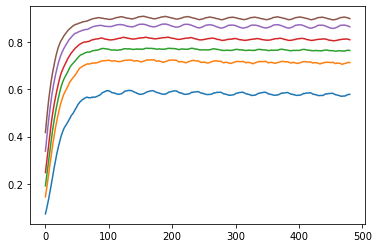

In [48]:
for i, _ in enumerate(n_values):
    plt.plot(np.convolve(f_c[:, i], np.ones(20)/20, mode='valid'))

In [ ]:
plt.plot(np.convolve(f_c[:200, 5], np.ones(20)/20, mode='valid'))

In [ ]:
n_values = [1, 5, 10, 20, 50, 100]

In [ ]:
plt.plot(np.convolve(lists[3][:1000, 0], np.ones(20)/20, mode='valid'))

In [ ]:
print(np.mean(lists[0][-10000:, 0]))
print(np.mean(lists[1][-10000:, 0]))
print(np.mean(lists[2][-10000:, 0]))
print(np.mean(lists[3][-10000:, 0]))
print(np.mean(lists[4][:, 0]))